In [1]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio
!pip install torchsummary


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pickle
import copy
from PIL import Image
import pandas as pd
from torchsummary import summary
from torch.utils.data import random_split
import numpy as np

In [3]:
torch.cuda.empty_cache()

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomGrayscale(p=0.025),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform_train)
num_train = len(trainset)
num_val = int(num_train * 0.10)  
num_train -= num_val  

train_dataset, val_dataset = random_split(trainset, [num_train, num_val])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)                                          

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


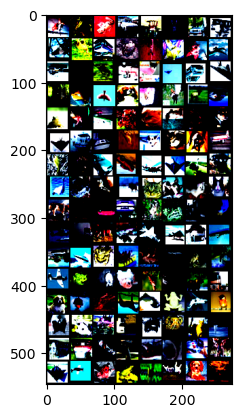

 ship  frog  frog truck horse   cat   car truck  bird  deer   car  frog  deer   cat   dog plane truck   cat  bird truck   dog plane   car plane   cat   car  bird   dog   dog   dog  deer   car


In [4]:
import matplotlib.pyplot as plt

dataiter = iter(trainloader)
images, labels = next(dataiter)
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0))
plt.show()
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))


In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3,drop_prob=0.5):
        super(BasicBlock, self).__init__()
        self.drop_prob = drop_prob
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels * BasicBlock.expansion,
            kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * BasicBlock.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out, p=self.drop_prob, training=self.training)      # L1 Regularization
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,drop_prob=0.5):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.drop_prob = drop_prob
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)     #changed from 512 to 256
        
        self.linear = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out=F.adaptive_avg_pool2d(out,(1,1))
        out = torch.flatten(out, 1)
        out = F.dropout(out, p=self.drop_prob, training=self.training)
        out = self.linear(out)
        return out
        
        
def resnet18():
    return ResNet18(BasicBlock, [3, 3, 2, 1])   #changed from [2,2,2,2] to [3,3,2,1]

In [6]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = resnet18()
net.linear = nn.Linear(256, 10)
net.to(device)

valid_loss_min = np.Inf             # setting from many necessray parameters
criterion = nn.CrossEntropyLoss()
counter=0
best_acc = 0
Lr=0.01
savename='project.pth'
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
lr_rates = []  
lr_rates2 = []
for epoch in range(300):
    if counter >= 10:           # specified learning rate scheduler
        counter = 0
        Lr = Lr * 0.5
        
    optimizer=optim.SGD(net.parameters(), lr=Lr, momentum=0.9, weight_decay=5e-3)   #L2 Regularization
    running_loss = 0.0
    total_batches = 0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        net.train()
        inputs, labels = data
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_batches += 1

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)  
    train_accuracies.append(100 * correct / total)
    print(f'Epoch {epoch + 1} complete. Average loss: {running_loss / total_batches:.6f}')
    
    net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)  # Get the predictions
            total_val += labels.size(0)  # Increment the total count
            correct_val += (predicted == labels).sum().item() 
    
    val_loss =val_loss/ len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(100 * correct_val / total_val)
    lr_rates.append(Lr)
    lr_rates2.append(optimizer.param_groups[0]['lr'])

    val_acc=correct_val / total_val
    print(f'Epoch {epoch+1} Validation loss: {val_loss:.4f}')
    
    if val_loss < valid_loss_min: 
        best_acc = val_acc
        best_model_wts = copy.deepcopy(net.state_dict())
        state = {
            'state_dict': net.state_dict(),
            'best_acc': best_acc,
            'optimizer': optimizer.state_dict(),
             }
                    
        torch.save(state, savename)
        print("the best model has been saved, the accuracy is {:.2f}%，filename：{}".format(best_acc * 100, savename))
        valid_loss_min = val_loss
        counter = 0
    else:
        counter += 1


print('Finished Training')            

Epoch 1 complete. Average loss: 1.911535
Epoch 1 Validation loss: 2.3383
the best model has been saved, the accuracy is 25.36%，filename：project.pth
Epoch 2 complete. Average loss: 1.592936
Epoch 2 Validation loss: 1.6923
the best model has been saved, the accuracy is 40.40%，filename：project.pth
Epoch 3 complete. Average loss: 1.400415
Epoch 3 Validation loss: 1.8283
Epoch 4 complete. Average loss: 1.273966
Epoch 4 Validation loss: 1.4531
the best model has been saved, the accuracy is 50.54%，filename：project.pth
Epoch 5 complete. Average loss: 1.183485
Epoch 5 Validation loss: 1.2839
the best model has been saved, the accuracy is 53.22%，filename：project.pth
Epoch 6 complete. Average loss: 1.114641
Epoch 6 Validation loss: 1.5196
Epoch 7 complete. Average loss: 1.065162
Epoch 7 Validation loss: 1.0715
the best model has been saved, the accuracy is 61.58%，filename：project.pth
Epoch 8 complete. Average loss: 1.027489
Epoch 8 Validation loss: 1.1040
Epoch 9 complete. Average loss: 0.993974


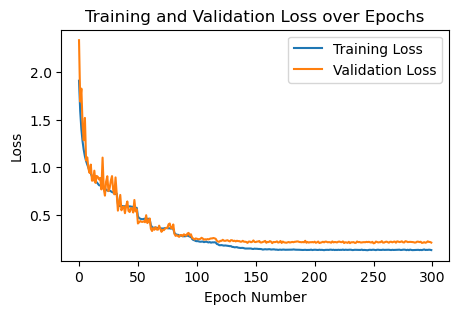

In [7]:
plt.figure(figsize=(5, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('training_validation_loss.png')
plt.show()

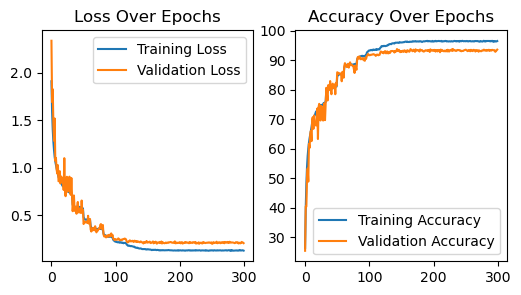

In [8]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()


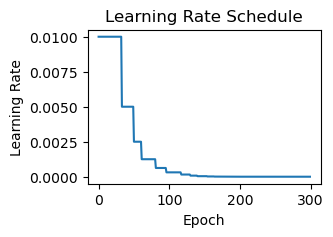

In [9]:
plt.figure(figsize=(3, 2))
plt.plot(lr_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

In [10]:
net.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

summary(net, input_size=(3, 32, 32))

Accuracy of the network on the 10000 test images: 93.11 %
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 3

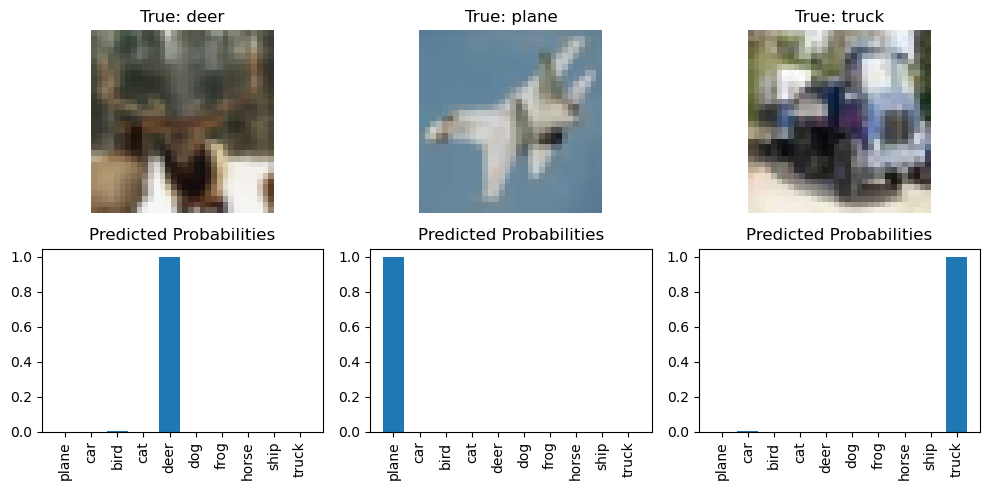

In [11]:
import random

# Get a batch of test images
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

# Select three random images from the batch
indices = random.sample(range(len(images)), 3)
images_subset = images[indices]
labels_subset = labels[indices]

# Perform predictions
with torch.no_grad():
    outputs = net(images_subset)

# Convert outputs to probabilities
probabilities = F.softmax(outputs, dim=1)

# Visualize the images and the class probabilities
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

for i, (image, label) in enumerate(zip(images_subset, labels_subset)):
    image_cpu = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_cpu = std * image_cpu + mean
    image_cpu = np.clip(image_cpu, 0, 1)

    axs[0, i].imshow(image_cpu)
    axs[0, i].set_title(f'True: {classes[label]}')
    axs[0, i].axis('off')

    axs[1, i].bar(np.arange(len(classes)), probabilities[i].cpu())
    axs[1, i].set_xticks(np.arange(len(classes)))
    axs[1, i].set_xticklabels(classes, rotation=90)
    axs[1, i].set_title('Predicted Probabilities')

plt.tight_layout()
plt.show()

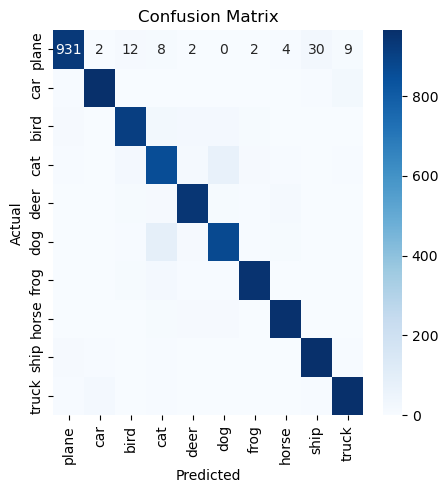

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = []
pred_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [13]:
with open('cifar_test_nolabels.pkl', 'rb') as file:
    test_data = pickle.load(file)

data = test_data[b'data']
ids = test_data[b'ids']

predictions = []
for i in range(len(data)):
    image_array = data[i].reshape(3, 32, 32).transpose(1, 2, 0)
    image = Image.fromarray(image_array)
    image = transform_test(image)  
    image = image.unsqueeze(0) 
    image = image.to(device)
    output = net(image)
    _, predicted = torch.max(output.data, 1)
    predictions.append((ids[i], predicted.item()))

df_predictions = pd.DataFrame(predictions, columns=['ID', 'Label'])

csv_filename = 'predictions.csv'
df_predictions.to_csv(csv_filename, index=False)

print(f'Predictions are saved to {csv_filename}')


Predictions are saved to predictions.csv
